# Preprocessing of all csv files from 2021 and 2022

In [1]:
# Import all the required library for preprocessing
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

In [2]:
# Read and import all csv into pandas...
# All the csv files are read from local/data/csv

all_files = glob.glob("data/*.csv")

li = [pd.read_csv(filename, index_col=None, header=0, low_memory=False) for filename in all_files]

# Merge all csv into one df...
df = pd.concat(li, axis=0, ignore_index=True)

# Delete all columns not of interest...
df = df.drop(df.columns[10:], axis=1)
df = df.drop(['SecondaryActivityCode', 'DescriptiveLabel','StartDate', 'UniBathWeekNo', 'DayOfWeek'], axis=1)

# Select all the data with no NaN and replace the result to df...
for col in df.columns:
    df = df[df[f'{col}'].notna()]
    
# Process duration into positive values and look for appropriate durations...
df['DurationMins'] = abs(df['DurationMins'])
df['DurationMins'] = df['DurationMins'].astype(str)
df = df[df['DurationMins'].str.len() < 6]

# Process enjoyment score into strings so values can be looked up in later stages...
df['EnjoymentScore'] = df['EnjoymentScore'].astype(str)

# Process Activity codes and turn them all into activity names...
df['PrimaryActivityCode'] = df['PrimaryActivityCode'].astype(str).str.replace(' ', '', regex= True)
old = ['Other(O733)','Travelling(T695)', 'Coursework(CW982)', 'Education/Lectures(EL642)', 'Sleep(S801)', 'PaidWork(PW101)', 'Eating/Drinking(ED145)', 'UseDevice(UD415)', 'ED152', 'R253', 'UB415', 'EL162', 'CW892', 'UD416', 'ED415', 'L352', '0733', 'shopping']
new = ['O733','T695', 'CW982', 'EL642', 'S801', 'PW101', 'ED145', 'UD415', 'ED145', 'R523', 'UD415', 'EL642', 'CW982', 'UD415', 'ED145', 'L418', 'O733', 'H179']
df['PrimaryActivityCode'] = df['PrimaryActivityCode'].str.strip().replace(dict(zip(old, new)))

activity_codes = ['ED145', 'EL642', 'X893', 'H179', 'L418', 'R523', 'S801', 'T695', 'UD415', 'PW101', 'CW982', 'O733']
activity_names = ['Eating/Drinking', 'Education/Lectures', 'Exercise', 'Housework', 'Leisure', 'Reading', 'Sleep', 'Travelling', 'Using Devices', 'Paid Work', 'Coursework', 'Other']
df['PrimaryActivityCode'] = df['PrimaryActivityCode'].str.strip().replace(dict(zip(activity_codes, activity_names)))

# Process Start time and End time...
df['StartTime'] = df['StartTime'].astype(str).str.replace(' AM', '')
df['StartTime'] = df['StartTime'].str.replace(' PM', '')

df['EndTime'] = df['EndTime'].astype(str).str.replace(' AM', '')
df['EndTime'] = df['EndTime'].str.replace(' PM', '')
df['EndTime'] = df['EndTime'].str.replace('24:00', '00:00')

# Format time into hours:minutes format...
df['StartTime'] = df['StartTime'].apply(lambda x: x if len(x) == 5 else x[0:5])
df['StartTime'] = df['StartTime'].str.replace(r':$', '', regex=True)
df['StartTime'] = df['StartTime'].apply(lambda x: '0'+x if len(x) == 4 else x)

df['EndTime'] = df['EndTime'].apply(lambda x: x if len(x) == 5 else x[0:5])
df['EndTime'] = df['EndTime'].str.replace(r':$', '', regex=True)
df['EndTime'] = df['EndTime'].apply(lambda x: '0'+x if len(x) == 4 else x)


Some of the data recorded in the time diary are not relevant to make a conclusion, such as University week number, as most of the week number would be the same. Since the assignment is done during a limited time period, anything related to date, week number and day of week should be removed, as it doesn't correlate to anything and not of interest. For secondary activities, there were only one-third of useful data out of the total 5810 recorded, therefore it is decided that it would be removed.

# Data plotting and statistics gatherings for 2021 and 2022 data

In [3]:
df.sort_values(by=['StartTime'])

,PrimaryActivityCode,StartTime,EndTime,DurationMins,EnjoymentScore
0,Sleep,00:00,07:00,420.0,2.0
2274,Sleep,00:00,08:00,480.0,0.0
2286,Sleep,00:00,08:00,480.0,0.0
1054552,Sleep,00:00,09:00,540.0,1.0
414,Sleep,00:00,03:00,180.0,2.0
...,...,...,...,...,...
1650,Leisure,23:45,00:00,15.0,1.0
1237,Sleep,23:45,08:00,495.0,2.0
985,Using Devices,23:45,00:00,15.0,0.0
1055869,Sleep,23:50,07:30,460.0,-1.0


In [4]:
df["StartTime"] = df["StartTime"].astype(str).str.replace(r'.{3}$', '', regex=True)
no_of_counts = df.groupby(['StartTime', 'PrimaryActivityCode']).size().reset_index(name='counts')
no_of_counts

,StartTime,PrimaryActivityCode,counts
0,00,Coursework,23
1,00,Eating/Drinking,4
2,00,Education/Lectures,5
3,00,Housework,1
4,00,Leisure,24
...,...,...,...
258,23,Paid Work,1
259,23,Reading,25
260,23,Sleep,87
261,23,Travelling,6


Counting the number of occurrence in each activity at a certain hour. By doing this, we can search up individual activity and plot a chart to see when do people start doing the a specific activity. For example:

<BarContainer object of 24 artists>

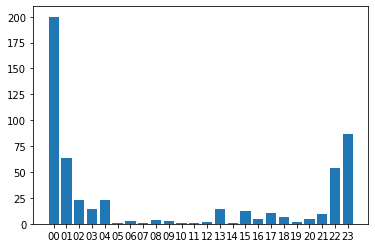

In [5]:
no_of_counts_sleep = no_of_counts[no_of_counts['PrimaryActivityCode'].str.match('Sleep')]
plt.bar(no_of_counts_sleep['StartTime'], no_of_counts_sleep['counts'])

From this bar chart, it can be recognised that people normally go to sleep around 23:00 to 00:00

<BarContainer object of 23 artists>

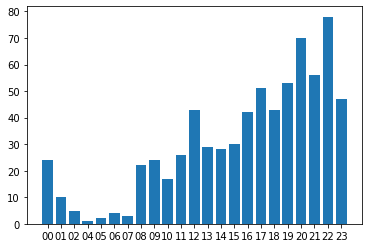

In [6]:
no_of_counts_leisure = no_of_counts[no_of_counts['PrimaryActivityCode'].str.match('Leisure')]
plt.bar(no_of_counts_leisure['StartTime'], no_of_counts_leisure['counts'])

From this bar chart, it can be observed that the leisure activity has been steadily increase since 17:00, until it reaches 22:00

For the next statistic, I wish to collect the activity proportion to see the how frequent each of these activity are done. A pie chart is later plotted using these values on the infographics

In [7]:
df['PrimaryActivityCode'].value_counts()

Eating/Drinking       1139
Leisure                708
Coursework             658
Education/Lectures     585
Other                  553
Sleep                  546
Travelling             419
Using Devices          369
Housework              282
Exercise               263
Reading                208
Paid Work               80
Name: PrimaryActivityCode, dtype: int64

# Enjoyment score statistics

To see if the student enjoys the activities, both the activity and the enjoyment score are grouped together:

In [8]:
no_of_counts_enjoy = df.groupby(['EnjoymentScore', 'PrimaryActivityCode']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
no_of_counts_enjoy

,EnjoymentScore,PrimaryActivityCode,counts
37,1.0,Eating/Drinking,510
49,2.0,Eating/Drinking,423
53,2.0,Leisure,407
57,2.0,Sleep,283
30,0.0,Other,234
41,1.0,Leisure,230
24,0.0,Coursework,208
38,1.0,Education/Lectures,192
34,0.0,Travelling,189
36,1.0,Coursework,187


And the group results are splited into positive and negative results:

In [9]:
no_of_counts_enjoy['EnjoymentScore'].astype(str)
negative = no_of_counts_enjoy[(no_of_counts_enjoy['EnjoymentScore'].str.match('-2')) | (no_of_counts_enjoy['EnjoymentScore'].str.match('-1'))].sort_values(by=['counts'], ascending=False)

negative['percent'] = (negative['counts']/negative['counts'].sum())*100
negative

,EnjoymentScore,PrimaryActivityCode,counts,percent
0,-1.0,Coursework,132,15.980630
2,-1.0,Education/Lectures,126,15.254237
12,-2.0,Coursework,91,11.016949
10,-1.0,Travelling,69,8.353511
4,-1.0,Housework,67,8.111380
16,-2.0,Housework,53,6.416465
14,-2.0,Education/Lectures,37,4.479419
6,-1.0,Other,36,4.358354
1,-1.0,Eating/Drinking,36,4.358354
8,-1.0,Reading,23,2.784504


A percentage is also showned next to each group results

In [10]:
positive = no_of_counts_enjoy[(no_of_counts_enjoy['EnjoymentScore'].str.match('2')) | (no_of_counts_enjoy['EnjoymentScore'].str.match('1'))].sort_values(by=['counts'], ascending=False)
positive['percent'] = (positive['counts']/positive['counts'].sum())*100
positive

,EnjoymentScore,PrimaryActivityCode,counts,percent
37,1.0,Eating/Drinking,510,13.995609
49,2.0,Eating/Drinking,423,11.608123
53,2.0,Leisure,407,11.169045
57,2.0,Sleep,283,7.766191
41,1.0,Leisure,230,6.311745
38,1.0,Education/Lectures,192,5.268935
36,1.0,Coursework,187,5.131723
47,1.0,Using Devices,172,4.720088
42,1.0,Other,162,4.445664
45,1.0,Sleep,141,3.869374


# Individual activity enjoyment score statistics (based on activity)

In [11]:
cw = no_of_counts_enjoy[no_of_counts_enjoy['PrimaryActivityCode'].str.match('Coursework')].sort_values(by=['counts'], ascending=False)
cw['percent'] = (cw['counts']/cw['counts'].sum())*100
cw

,EnjoymentScore,PrimaryActivityCode,counts,percent
24,0.0,Coursework,208,31.610942
36,1.0,Coursework,187,28.419453
0,-1.0,Coursework,132,20.060790
12,-2.0,Coursework,91,13.829787
48,2.0,Coursework,40,6.079027


In [12]:
total_leisure = no_of_counts_enjoy[no_of_counts_enjoy['PrimaryActivityCode'].str.match('Leisure')].sort_values(by=['counts'], ascending=False)
total_leisure['percent'] = (total_leisure['counts']/total_leisure['counts'].sum())*100
total_leisure

,EnjoymentScore,PrimaryActivityCode,counts,percent
53,2.0,Leisure,407,57.485876
41,1.0,Leisure,230,32.485876
29,0.0,Leisure,51,7.203390
5,-1.0,Leisure,16,2.259887
17,-2.0,Leisure,4,0.564972


## Duration of every activity

In [13]:
dur = df.groupby(['PrimaryActivityCode', 'DurationMins']).size().reset_index(name='counts').sort_values(by=['DurationMins'], ascending=False)
dur

,PrimaryActivityCode,DurationMins,counts
438,Sleep,975.0,3
437,Sleep,960.0,2
140,Education/Lectures,95.0,1
100,Eating/Drinking,95.0,1
467,Travelling,95.0,1
...,...,...,...
267,Other,100.0,1
53,Eating/Drinking,10.0,1
205,Leisure,10.0,1
468,Using Devices,10.0,1


## Group the maximum duration of each activity for bar plot

In [14]:
activity_list = dur['PrimaryActivityCode'].unique()
lst_of_max_dur = []
for activity in activity_list:
    activity_durations = dur[dur['PrimaryActivityCode'].str.match(f'{activity}')]
    activity_durations['DurationMins'] = pd.to_numeric(activity_durations['DurationMins'])
    maximum_durations = max(activity_durations['DurationMins'])
    lst_of_max_dur.append(maximum_durations)

lst_of_max_dur

[975.0,
 825.0,
 780.0,
 420.0,
 895.0,
 300.0,
 375.0,
 510.0,
 330.0,
 600.0,
 810.0,
 600.0]

In [15]:
activity_list

array(['Sleep', 'Education/Lectures', 'Eating/Drinking', 'Travelling',
       'Coursework', 'Other', 'Using Devices', 'Housework', 'Exercise',
       'Paid Work', 'Reading', 'Leisure'], dtype=object)

## Sum of all duration in this time diary in hours

In [16]:
df['DurationMins'] = pd.to_numeric(df['DurationMins'])
(df['DurationMins'].sum())/60

10483.416666666666

# Preprocessing american survey data

## Please go to kaggle and search up American Time Use Survey to get atusact.csv and codes.csv. Once that is done, place the csv into the local folder

In [17]:
df2 = pd.read_csv('atusact.csv')
df2 = df2[['trtier1p','tustarttim', 'tustoptime', 'tuactdur']]
df2 = df2.rename(columns={'trtier1p': 'PrimaryActivityCode','tuactdur':'DurationMins', 'tustarttim':'StartTime', 'tustoptime':'EndTime'})

In [18]:
activty_code_name = pd.read_csv('codes.csv')
activty_code_name = activty_code_name.astype(str)
activty_code_name = activty_code_name.loc[activty_code_name['code'].str.len() <= 2]
codes = list(activty_code_name['code'])
names = list(activty_code_name['name'])

In [19]:
df2['PrimaryActivityCode'] = df2['PrimaryActivityCode'].astype(str).str.strip().replace(dict(zip(codes, names)))

In [20]:
df2 = df2[df2["PrimaryActivityCode"].str.contains("Data Codes") == False]

In [21]:
df2

,PrimaryActivityCode,StartTime,EndTime,DurationMins
0,"Sports, Exercise, & Recreation",04:00:00,05:00:00,60
1,Personal Care Activities,05:00:00,05:30:00,30
2,Personal Care Activities,05:30:00,15:30:00,600
3,"Socializing, Relaxing, and Leisure",15:30:00,18:00:00,150
4,Eating and Drinking,18:00:00,18:05:00,5
...,...,...,...,...
3347088,Personal Care Activities,19:52:00,20:07:00,15
3347089,"Socializing, Relaxing, and Leisure",20:07:00,21:00:00,53
3347090,Caring For & Helping Household (HH) Members,21:00:00,21:15:00,15
3347091,"Socializing, Relaxing, and Leisure",21:15:00,00:00:00,165


# Data plotting and statistics gatherings for American survey

In [23]:
activty_code_name['name'].unique()

array(['Personal Care Activities', 'Household Activities',
       'Caring For & Helping Household (HH) Members',
       'Caring for & Helping Nonhousehold (NonHH) Members',
       'Work & Work-Related Activities', 'Education',
       'Consumer Purchases', 'Professional & Personal Care Services',
       'Household Services', 'Government Services & Civic Obligations',
       'Eating and Drinking', 'Socializing, Relaxing, and Leisure',
       'Sports, Exercise, & Recreation',
       'Religious and Spiritual Activities', 'Volunteer Activities',
       'Telephone Calls', 'Traveling', 'Data Codes'], dtype=object)

In [24]:
df2['PrimaryActivityCode'].value_counts()

Traveling                                            675992
Personal Care Activities                             618703
Socializing, Relaxing, and Leisure                   540203
Household Activities                                 476298
Eating and Drinking                                  338217
Caring For & Helping Household (HH) Members          181371
Work & Work-Related Activities                       153679
Consumer Purchases                                   117733
Sports, Exercise, & Recreation                        41550
Caring for & Helping Nonhousehold (NonHH) Members     41351
Telephone Calls                                       38151
Religious and Spiritual Activities                    27969
Education                                             21125
Volunteer Activities                                  20226
Professional & Personal Care Services                 17225
Household Services                                     4273
Government Services & Civic Obligations 

In [25]:
PerCareA_df = df2[df2['PrimaryActivityCode'].str.match('Personal Care Activities')]

In [26]:
PerCareA_df['DurationMins'].describe()

count    618703.000000
mean        204.855443
std         202.221054
min           1.000000
25%          30.000000
50%         120.000000
75%         360.000000
max        1455.000000
Name: DurationMins, dtype: float64

In [27]:
no_of_counts_df2 = df2.groupby(['StartTime', 'PrimaryActivityCode']).size().reset_index(name='counts')
no_of_counts_df2["StartTime"] = no_of_counts_df2["StartTime"].astype(str).str.replace(r'.{6}$', '', regex=True)
no_of_counts_df2

,StartTime,PrimaryActivityCode,counts
0,00,Caring For & Helping Household (HH) Members,288
1,00,Caring for & Helping Nonhousehold (NonHH) Members,56
2,00,Consumer Purchases,22
3,00,Eating and Drinking,292
4,00,Education,31
...,...,...,...
20137,23,Religious and Spiritual Activities,1
20138,23,"Socializing, Relaxing, and Leisure",13
20139,23,Telephone Calls,1
20140,23,Traveling,7


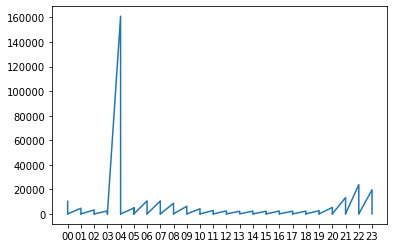

In [28]:
no_of_counts_PerCareA_american = no_of_counts_df2[no_of_counts_df2['PrimaryActivityCode'].str.match('Personal Care Activities')]
plt.plot(no_of_counts_PerCareA_american['StartTime'], no_of_counts_PerCareA_american['counts'])

In [29]:
df2[df2['DurationMins'] <= 15]

,PrimaryActivityCode,StartTime,EndTime,DurationMins
4,Eating and Drinking,18:00:00,18:05:00,5
7,Personal Care Activities,01:30:00,01:40:00,10
13,Traveling,10:00:00,10:10:00,10
15,Traveling,19:00:00,19:10:00,10
22,Traveling,10:30:00,10:35:00,5
...,...,...,...,...
3347082,Traveling,18:25:00,18:27:00,2
3347083,Household Activities,18:27:00,18:37:00,10
3347085,Household Activities,19:02:00,19:07:00,5
3347088,Personal Care Activities,19:52:00,20:07:00,15


In [30]:
done_under_15_min = 1090680/3315244
done_under_15_min

0.32898935945589525

In [31]:
dur2 = df2.groupby(['PrimaryActivityCode', 'DurationMins']).size().reset_index(name='counts').sort_values(by=['DurationMins'], ascending=False)
dur2

,PrimaryActivityCode,DurationMins,counts
7748,Work & Work-Related Activities,1472,1
3878,Personal Care Activities,1455,1
7747,Work & Work-Related Activities,1440,7
6451,Traveling,1440,1
5338,"Socializing, Relaxing, and Leisure",1440,2
...,...,...,...
5818,Telephone Calls,1,1178
6062,Traveling,1,16683
6452,Volunteer Activities,1,179
6871,Work & Work-Related Activities,1,530


In [32]:
# dur2['DurationMins'] = dur2['DurationMins'].astype(str)

activity_list2 = dur2['PrimaryActivityCode'].unique()
lst_of_max_dur2 = []
for activity2 in activity_list2:
    activity_durations2 = dur2[dur2['PrimaryActivityCode'].str.match(f'{activity2}')]
    activity_durations2['DurationMins'] = pd.to_numeric(activity_durations2['DurationMins'])
    maximum_durations2 = activity_durations2['DurationMins'].max()/60
    lst_of_max_dur2.append(maximum_durations2)

lst_of_max_dur2

[24.533333333333335,
 24.25,
 24.0,
 24.0,
 nan,
 23.983333333333334,
 23.933333333333334,
 23.75,
 23.333333333333332,
 nan,
 21.666666666666668,
 19.75,
 16.75,
 15.5,
 14.0,
 10.5,
 7.833333333333333]

In [33]:
(df2[df2['PrimaryActivityCode'].str.match('Caring for')]['DurationMins'].max())/60

22.333333333333332

In [34]:
df2[df2['PrimaryActivityCode'].str.match('Caring For')]['DurationMins'].max()/60

23.983333333333334